# Drone Trajectory Planner

In this project, we will develop the drone trajectory planner. This notebook serves as the main file for the project, where we will refer to the instructions and demonstrate our code.

Please follow week by week instructions, which includes writing the code in the `src/` folder.

In [3]:
# Import all the files and libraries required for the project
%load_ext autoreload
%autoreload 2
import copy
    
import numpy as np

from src.camera_utils import compute_image_footprint_on_surface, compute_ground_sampling_distance, project_world_point_to_image
from src.data_model import Camera, DatasetSpec
from src.plan_computation import compute_distance_between_images, compute_speed_during_photo_capture, generate_photo_plan_on_grid
from src.visualization import plot_photo_plan

import plotly.io as pio
pio.renderers.default = 'iframe'

# Week 1: Introduction

No code contribution expected this week

# Week 2: Implement data models for dataset specification and camera

For this week, we will model the dataset specification.

- Overlap: the ratio (in 0 to 1) of scene shared between two consecutive images.
- Sidelap: the ratio (in 0 to 1) of scene shared between two images in adjacent rows.
- Height: the height of the scan above the ground (in meters).
- Scan_dimension_x: the horizontal size of the rectangle to be scanned (in meters).
- Scan_dimension_y: the vertical size of the rectangle to be scanned (in meters).
- exposure_time_ms: the exposure time for each image (in milliseconds).


$\color{red}{\text{TODO: }}$ Implement `DatasetSpec` in `src/data_model.py`


In [5]:
# Model the nomimal dataset spec

overlap = 0.7
sidelap = 0.7
height = 30.48 # 100 ft
scan_dimension_x = 150
scan_dimension_y = 150
exposure_time_ms = 2 # 1/500 exposure time

dataset_spec = DatasetSpec(overlap, sidelap, height, scan_dimension_x, scan_dimension_y, exposure_time_ms)

print(f"Nominal specs: {dataset_spec}")

Nominal specs: DatasetSpec(overlap=0.7, sidelap=0.7, height=30.48, scan_dimension_x=150, scan_dimension_y=150, exposure_time_ms=2)


## Model the camera parameters

We want to model the following camera parameters in Python:
- focal length along x axis (in pixels)
- focal length along y axis (in pixels)
- optical center of the image along the x axis (in pixels)
- optical center of the image along the y axis (in pixels)
- Size of the sensor along the x axis (in mm)
- Size of the sensor along the y axis (in mm)
- Number of pixels in the image along the x axis
- Number of pixels in the image along the y axis

I recommend to use `dataclasses` ([Python documentation](https://docs.python.org/3/library/dataclasses.html), [Blog](https://www.dataquest.io/blog/how-to-use-python-data-classes/) to model these parameters.

$\color{red}{\text{TODO: }}$ Implement `Camera` in `src/data_model.py`

In [6]:
# Define the parameters for Skydio VT300L - Wide camera
# Ref: https://support.skydio.com/hc/en-us/articles/20866347470491-Skydio-X10-camera-and-metadata-overview
fx = 4938.56
fy = 4936.49
cx = 4095.5
cy = 3071.5
sensor_size_x_mm = 13.107 # single pixel size * number of pixels in X dimension
sensor_size_y_mm = 9.830 # single pixel size * number of pixels in Y dimension
image_size_x = 8192
image_size_y = 6144

camera_x10 = Camera(fx, fy, cx, cy, sensor_size_x_mm, sensor_size_y_mm, image_size_x, image_size_y)

In [4]:
print(f"X10 camera model: {camera_x10}")

X10 camera model: Camera(fx=4938.56, fy=4936.49, cx=4095.5, cy=3071.5, sensor_size_x_mm=13.107, sensor_size_y_mm=9.83, image_size_x_px=8192, image_size_y_px=6144)


# Week 3: Camera Operations

We plan to write utility functions to
- project a 3D world point to an image
- Compute image footprint on a surface
- Compute the Ground Sampling Distance

## Project 3D world points into the image


![Camera Projection](assets/image_projection.png)
Reference: [Robert Collins CSE483](https://www.cse.psu.edu/~rtc12/CSE486/lecture12.pdf)


Equations to implement:
$$ x = f_x \frac{X}{Z} $$
$$ y = f_y \frac{Y}{Z} $$
$$ u = x + c_x $$
$$ v = y + c_y $$

$\color{red}{\text{TODO: }}$ Implement function `project_world_point_to_image` in `src/camera_utils.py`

In [4]:
point_3d = np.array([25, -30, 50], dtype=np.float32)
expected_uv = np.array([6564.80, 109.60], dtype=np.float32)
uv = project_world_point_to_image(camera_x10, point_3d)

print(f"{point_3d} projected to {uv}")

assert np.allclose(uv, expected_uv, atol=1e-2)

[ 25. -30.  50.] projected to [6564.7803   109.60571]


## Compute Image Footprint on the surface

We have written code to *project* a 3D point into the image. The reverse operation is reprojection, where we take $(x, y)$ and compute the $(X, Y)$ for a given value of $Z$. Note that while going from 3D to 2D, the depth becomes ambiguous so we need the to specify the $Z$.

An image's footprint is the area on the surface which is captured by the image. We can take the two corners of the image and reproject them at a given distance to obtain the width and length of the image.

$\color{red}{\text{TODO: }}$ Implement function `compute_image_footprint_on_surface` in `src/camera_utils.py`

In [5]:
footprint_at_100m = compute_image_footprint_on_surface(camera_x10, 100)
expected_footprint_at_100m = np.array([165.88, 124.46], dtype=np.float32)

print(f"Footprint at 100m = {footprint_at_100m}")

assert np.allclose(footprint_at_100m, expected_footprint_at_100m, atol=1e-2)


Footprint at 100m = [165.87831271 124.46090238]


In [6]:
footprint_at_200m = compute_image_footprint_on_surface(camera_x10, 200)
expected_footprint_at_200m = expected_footprint_at_100m * 2

print(f"Footprint at 200m = {footprint_at_200m}")

assert np.allclose(footprint_at_200m, expected_footprint_at_200m, atol=1e-2)

Footprint at 200m = [331.75662541 248.92180476]


## Ground Sampling Distance

Ground sampling distance is the length of the ground (in m) captured by a single pixel. We have the image footpring (the dimensions of ground captured by the whole sensor, and the number of pixels along the horizontal and vertical dimension. Can we get GSD from these two quantities?

Note: Please return just one value of the GSD. Take the mininum of the values along the two axes.

In [7]:
gsd_at_100m = compute_ground_sampling_distance(camera_x10, 100)
expected_gsd_at_100m = 0.0202

print(f"GSD at 100m: {gsd_at_100m}")

assert np.allclose(gsd_at_100m, expected_gsd_at_100m, atol=1e-4)

GSD at 100m: 0.020248817469059807


## Bonus: Reprojection from 2D to 3D

If we have a 2d pixel location of a point along with the camera model, can we go back to 3D?
Do we need any additional information.


$\color{red}{\text{TODO: }}$ Implement function `reproject_image_point_to_world` in `src/camera_utils.py` and demonstrate it by running it in the notebook. Confirm that your reprojection + projection function are by projecting a 3d point to image, and reprojecting it back to 3D.

# Week 4: Compute Distance Between Photos

The overlap and sidelap are the ratio of the dimensions shared between two photos. We already know the footprint of a single image at a given distance. Can we convert the ratio into actual distances? And how does the distance on the surface relate to distance travelled by the camera?

$\color{red}{\text{TODO: }}$ Implement `compute_distance_between_images` in `src/plan_computation.py`



In [8]:
computed_distances = compute_distance_between_images(camera_x10, dataset_spec)
expected_distances = np.array([15.17, 11.38], dtype=np.float32)

print(f"Computed distance for X10 camera with nominal dataset specs: {computed_distances}")

assert np.allclose(computed_distances, expected_distances, atol=1e-2)

Computed distance for X10 camera with nominal dataset specs: [15.16791291 11.38070491]


$\color{red}{\text{TODO: }}$ define >=2 more specifications/camera parameters and check the computed distances. Does that align with your expections


In [9]:
camera_ = copy.copy(camera_x10)
dataset_spec_ = copy.copy(dataset_spec)

computed_distances_ = compute_distance_between_images(camera_, dataset_spec_)
print(f"Computed distance: {computed_distances_}")


# Test different scenarios
camera_ = copy.copy(camera_x10)
dataset_spec_ = copy.copy(dataset_spec)
computed_base = compute_distance_between_images(camera_, dataset_spec_)
print("Base (camera_x10):", computed_base)

#Increasing height
#result: Height 100m: [30.32089678 22.75020835]
camera_ = copy.copy(camera_x10)
dataset_spec_ = copy.copy(dataset_spec)
dataset_spec_.height = 60.93
computed_height_100 = compute_distance_between_images(camera_, dataset_spec_)
print("Height 100m:", computed_height_100)

#Decreasing height
#result: Height 50m: [7.58395646 5.69035246]
camera_ = copy.copy(camera_x10)
dataset_spec_ = copy.copy(dataset_spec)
dataset_spec_.height = 15.24
computed_height_100 = compute_distance_between_images(camera_, dataset_spec_)
print("Height 50m:", computed_height_100)

#Decreasing overlap
#Overlap 50%: [25.27985486 11.38070491]
camera_ = copy.copy(camera_x10)
dataset_spec_ = copy.copy(dataset_spec)
dataset_spec_.overlap = 0.5
computed_overlap_50 = compute_distance_between_images(camera_, dataset_spec_)
print("Overlap 50%:", computed_overlap_50)

computed_distances = compute_distance_between_images(camera_x10, dataset_spec)
expected_distances = np.array([15.17, 11.38], dtype=np.float32)

print(f"Computed distance for X10 camera with nominal dataset specs: {computed_distances}")
#output:Computed distance for X10 camera with nominal dataset specs: [15.16791291 11.38070491]
assert np.allclose(computed_distances, expected_distances, atol=1e-2)

Computed distance: [15.16791291 11.38070491]
Base (camera_x10): [15.16791291 11.38070491]
Height 100m: [30.32089678 22.75020835]
Height 50m: [7.58395646 5.69035246]
Overlap 50%: [25.27985486 11.38070491]
Computed distance for X10 camera with nominal dataset specs: [15.16791291 11.38070491]


| **Test Scenario**    | **Changes Made**                        | **Expected Effect**                   | **Observed Result** | 
| -------------------- | --------------------------------------- | ------------------------------------- | ------------------- | 
| **Base Case**        | Default `camera_x10` and `dataset_spec` | Baseline for comparison               | `[15.17, 11.38]`    |
| **Increased Height** | `dataset_spec.height = 60.93`           | Larger footprint → larger distances   | `[30.32, 22.75]`    | 
| **Decreased Height** | `dataset_spec.height = 15.24`           | Smaller footprint → smaller distances | `[7.58, 5.69]`      | 
| **Reduced Overlap**  | `dataset_spec.overlap = 0.5`            | Less overlap → larger distances       | `[25.28, 11.38]`    | 


*Increased Height*: When camera sees more ground per image, fewer shots are needed because the drone can space each photo further apart.
Higher altitude = larger ground footprint = greater image spacing.

*Decreased Height*: When the drone fly lower, the camera will capture less area per image. This requires the drone to take more pictures to maintain overlap. 
Lower altitude = smaller footprint = closer image spacing.

*Reduced Overlap*: Less overlap means more distance between image centers because adjacent photos will share less common area. 
Less overlap = more spacing between images.

## Bonus: Non-Nadir photos

We have solved for the distance assuming that the camera is facing straight down to the ground. This is called [Nadir scanning](https://support.esri.com/en-us/gis-dictionary/nadir). However, in practise we might want a custom gimbal angle.

Your bonus task is to make the distance computation general. Introduce a double `camera_angle` parameter (which is the angle from the X-axis) in the dataset specification, and work out how to adapt your computation. Feel free to reach out to Ayush to discuss ideas and assumptions!

![Non Nadir Footprint](assets/non_nadir_gimbal_angle.png)

# Week 5: Compute Maximum Speed For Blur Free Photos

To restrict motion blur due to camera movement to tolerable limits, we need to restrict the speed such that the image contents move less than 1px away. 

How much does 1px of movement translate to movement of the scene on the ground? It is the ground sampling distance!
From previous week, we know that this is the maximum movement the camera can have. 
We have the distance now. To get speed we need to divide it with time. Do we have time already in our data models?

$\color{red}{\text{TODO: }}$ Implement `compute_speed_during_photo_capture` in `src/plan_computation.py`.

In [10]:
computed_speed = compute_speed_during_photo_capture(camera_x10, dataset_spec, allowed_movement_px=1)
expected_speed = 3.09

print(f"Computed speed during photo captures: {computed_speed:.2f}")

assert np.allclose(computed_speed, expected_speed, atol=1e-2)

Computed speed during photo captures: 3.09


$\color{red}{\text{TODO: }}$ define >= 2more specifications/camera parameters and check the computed distances. Does that align with your expectations


In [11]:
camera_ = copy.copy(camera_x10)
dataset_spec_ = copy.copy(dataset_spec)

computed_speed_ = compute_speed_during_photo_capture(camera_, dataset_spec_)
print(f"Computed speed: {computed_speed_:.2f}")



Computed speed: 3.09


In [12]:
camera_ = copy.copy(camera_x10)
dataset_spec_ = copy.copy(dataset_spec)
#test case scenario: increased height
dataset_spec_.height = 60.93
computed_speed_ = compute_speed_during_photo_capture(camera_, dataset_spec_)
print(f"Computed speed at increased height: {computed_speed_:.2f}")


Computed speed at increased height: 6.17


**Test 1**


Expected result: When the drone move faster without exceeding 1 px blur, the computed speed should increase. As the height increases, the camera will capture larger area per image -> larger footprint. Each pixel will represent more ground distance.

In [13]:
camera_ = copy.copy(camera_x10)
dataset_spec_ = copy.copy(dataset_spec)
#test case scenatio: decreased height
dataset_spec_.height = 15.24
computed_speed_ = compute_speed_during_photo_capture(camera_, dataset_spec_)
print(f"Computed speed at decreased height: {computed_speed_:.2f}")

Computed speed at decreased height: 1.54


**Test 2**

Expected Result: The computed speed should decrease. This is because at a lower altitude the camera captures finer details. The drone will move slowely and the pixel represents a smaller real world distance. This will reduce the maximum distance the drone can move before exceeding 1 px blur.

In [14]:
camera_ = copy.copy(camera_x10)
dataset_spec_ = copy.copy(dataset_spec)
#test case scenario: increased exposure time
dataset_spec_.height = 30.48
dataset_spec_.exposure_time_ms = 10 #longer shutter time
computed_speed_ = compute_speed_during_photo_capture(camera_, dataset_spec_)
print(f"Computed speed at increased exposure time: {computed_speed_:.2f}")

Computed speed at increased exposure time: 0.62


**Test 3**

Expected Result: The computed speed will decrease as exposure time increases. This is because the longer the exposure, the slower the camera will move to keep the image sharp. When we increase exposure time, the camera's shutter will remain open for a longer time. If drone moves fast, it will cause a noticeable blur.

In [15]:
camera_ = copy.copy(camera_x10)
dataset_spec_ = copy.copy(dataset_spec)
#test case scenario: half focal length
camera_.fx = camera_.fx * 0.5
camera_.fy = camera_.fy * 0.5
computed_speed_focal = compute_speed_during_photo_capture(camera_, dataset_spec_)
print(f"half focal length: computed speed = {computed_speed_focal:.2f} m/s")

half focal length: computed speed = 6.17 m/s


**Test 4**

Expected Result: With a decreased focal length, the computed speed should increase because with wide lens, the drone move faster without exceeding 1 px blur. Reducing the focal length gives camera a wider field of view and this allowss each pixel to cover larger portion of the ground.

# Week 6: Generate Full Flight Plans  

We now have all the tools to generate the full flight plan.

Steps for this week:
1. Define the `Waypoint` data model. What attributes should the data model have?
   1. For Nadir scans, just the position of the camera is enough as we will always look drown to the ground.
   2. For general case (bonus), we also need to define where the drone will look at.
3. Implement the function `generate_photo_plan_on_grid` to generate the full plan.
   1. Compute the maximum distance between two images, horizontally and vertically.
   2. Layer the images such that we cover the whole scan area. Note that you need to take care when the scan dimension is not a multiple of distance between images. Example: to cover 45m length with 10m between images, we would need 4.5 images. Not possible. 4 images would not satisfy the overlap, so we should go with 5. How should we arrange 5 images in the given 45m.
   3. Assign the speed to each waypoint.

$\color{red}{\text{TODO: }}$ Implement:
- `Waypoint` in `src/data_model.py`
- `generate_photo_plan_on_grid` in `src/plan_computation.py`.

In [7]:
computed_plan = generate_photo_plan_on_grid(camera_x10, dataset_spec) 

print(f"Computed plan with {len(computed_plan)} waypoints")

Computed plan with 140 waypoints


In [8]:
MAX_NUM_WAYPOINTS_TO_PRINT = 20

for idx, waypoint in enumerate(computed_plan[:MAX_NUM_WAYPOINTS_TO_PRINT]):
    print(f"Idx {idx}: {waypoint}")
if len(computed_plan) >= MAX_NUM_WAYPOINTS_TO_PRINT:
    print("...")

Idx 0: Waypoint(x=0.0, y=0.0, z=30.48, speed=0.0)
Idx 1: Waypoint(x=15.16791291388583, y=0.0, z=30.48, speed=0.0)
Idx 2: Waypoint(x=30.33582582777166, y=0.0, z=30.48, speed=0.0)
Idx 3: Waypoint(x=45.50373874165749, y=0.0, z=30.48, speed=0.0)
Idx 4: Waypoint(x=60.67165165554332, y=0.0, z=30.48, speed=0.0)
Idx 5: Waypoint(x=75.83956456942916, y=0.0, z=30.48, speed=0.0)
Idx 6: Waypoint(x=91.00747748331499, y=0.0, z=30.48, speed=0.0)
Idx 7: Waypoint(x=106.17539039720081, y=0.0, z=30.48, speed=0.0)
Idx 8: Waypoint(x=121.34330331108664, y=0.0, z=30.48, speed=0.0)
Idx 9: Waypoint(x=136.5112162249725, y=0.0, z=30.48, speed=0.0)
Idx 10: Waypoint(x=136.5112162249725, y=11.380704913815284, z=30.48, speed=0.0)
Idx 11: Waypoint(x=121.34330331108664, y=11.380704913815284, z=30.48, speed=0.0)
Idx 12: Waypoint(x=106.17539039720081, y=11.380704913815284, z=30.48, speed=0.0)
Idx 13: Waypoint(x=91.00747748331499, y=11.380704913815284, z=30.48, speed=0.0)
Idx 14: Waypoint(x=75.83956456942916, y=11.3807049

## Bonus: Time computation 

if you have some time, you can implement a time computation function. We can make the drone fly as fast as possible between photos, but make sure it can decelerate back to the required speed at the photos. Please use the following data: 
- Max drone speed: 16m/s.
- Max acceleration: 3.5 m/s^2.

Hint: you might need to use a trapezoidal/triangular speed profile

# Week 7: Visualize Flight Plans

This week, we will use a third party plotting framework called [Plotly](https://plotly.com/python/) to visualize our plans. Please follow this [tutorial](https://www.kaggle.com/code/kanncaa1/plotly-tutorial-for-beginners) to gain some basic experience with Plotly, and then come up with your own visualization function. You are free to choose to come up with your own visualization, and use something other than Plotly.

$\color{red}{\text{TODO: }}$ Implement `plot_photo_plan` in `src/visualization.py`

In [ ]:
fig = plot_photo_plan(computed_plan)
fig.show()

$\color{red}{\text{TODO: }}$ Perform the following experiments (and any other you can think of) where we change just one parameter of the input camera/dataset specification and observe the change in the output plan. 

1. Change overlap and confirm it affects the consecutive images
2. Change sidelap and confirm it does not affect the consecutive images
3. Change the height of the scan and document the affect on scan plans
4. Change exposure time

Each experiment should specify: 
1. Input params you are changing
2. Impact you observe
3. explanation behind the change in output (intuition based or a text explanation is preffered over using equations)
4. Practical implication of the correlation: how can I drone pilot use this result

In [ ]:
camera_ = copy.deepcopy(camera_x10)
dataset_spec_ = copy.deepcopy(dataset_spec)

dataset_spec_.exposure_time_ms = 1000

print(camera_, dataset_spec_)

fig = plot_photo_plan(generate_photo_plan_on_grid(camera_, dataset_spec_))
fig.show()

## Overlap

*Overlap 0.5*


Explanation of Experiment
1. Input Parameter: The overlap parameter is set to 0.5. Each photo overlaps 50% with the next image along the line.
2. Impact Observed: The spacing between consecutive images increased and there are fewer total waypoints.
3. Output: Lower overlap reduces how much adjacent photos share in coverage, so the drone will move at a greater distance between captures.

**How can a drone pilot use this result?**

A drone pilot can use a lower overlap to shorten flight time and reduce image count. This may lead to gaps in mapping and 3D reconstruction.



In [24]:
camera_ = copy.deepcopy(camera_x10)
dataset_spec_ = copy.deepcopy(dataset_spec)
dataset_spec_.overlap = 0.5

fig = plot_photo_plan(generate_photo_plan_on_grid(camera_, dataset_spec_))
#fig.show()
fig.show(renderer="browser")



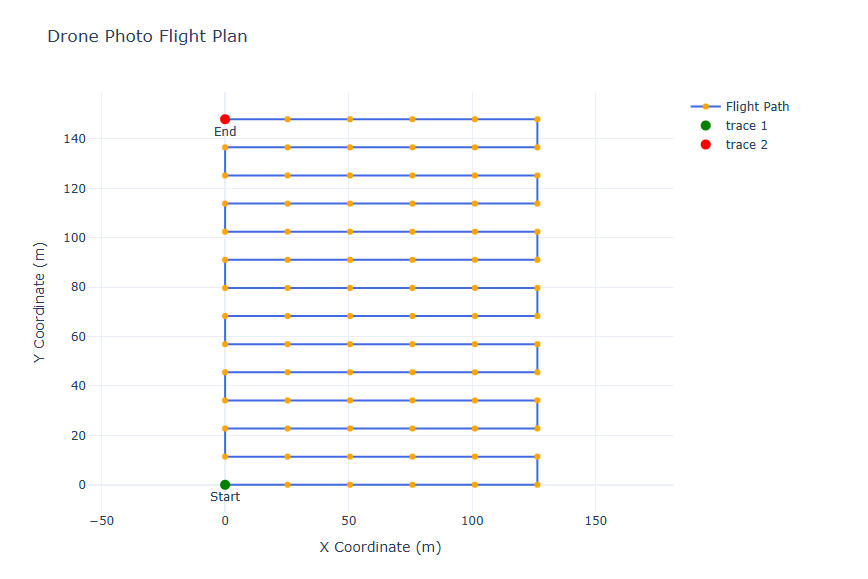

*Overlap 0.9*


Explanation of Experiment
1. Input Parameter: The overlap parameter is set to 0.9. Each photo overlaps 90% with the next image along the line.
2. Impact Observed: The spacing between consecutive images decreased, producing many more waypoints and denser scan pattern.
3. Output: Higher overlap allows more area to be captureed repeatedly by adjacent photos. Drone will take images more frequently.



**How can a drone pilot use this result?**

A drone pilot can use a higher overlap to improve image matching and reconstruction accuracy. It increases flight time and storage requirements.

In [25]:
camera_ = copy.deepcopy(camera_x10)
dataset_spec_ = copy.deepcopy(dataset_spec)
dataset_spec_.overlap = 0.9

fig = plot_photo_plan(generate_photo_plan_on_grid(camera_, dataset_spec_))
#fig.show()
fig.show(renderer="browser")

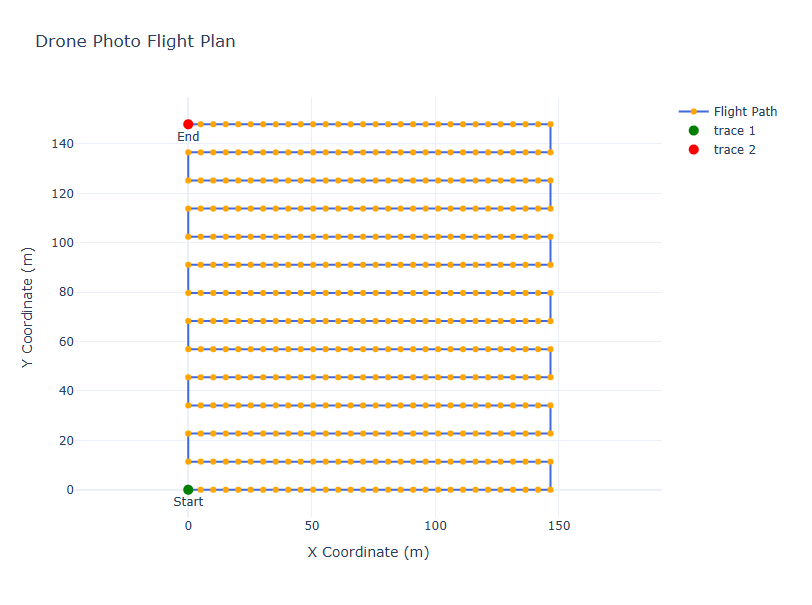

## Sidelap

In [39]:
for s in [0.5, 0.8]:
    camera_ = copy.deepcopy(camera_x10)
    dataset_spec_ = copy.deepcopy(dataset_spec)
    dataset_spec_.sidelap = s

    fig = plot_photo_plan(generate_photo_plan_on_grid(camera_, dataset_spec_))
    fig.update_layout(title=f"Sidelap = {s}")
    fig.show(renderer="browser")


In [40]:
for s in [0.5, 0.8]:
    dataset_spec_.sidelap = s
    dist = compute_distance_between_images(camera_, dataset_spec_)
    print(f"Sidelap {s}: Distance between rows (y) = {dist[1]:.2f}")


Sidelap 0.5: Distance between rows (y) = 18.97
Sidelap 0.8: Distance between rows (y) = 7.59


*Sidelap 0.5*


Explanation of Experiment
1. Input Parameter: The sidelap parameter is set to 0.5. Each photo overlaps 50% with the next image along the line.
2. Impact Observed: The distance between rows decreased slightly, but no change to the overlap between consecutive images in the same row.
3. Output: Sidelap checks how much overlap exist between neighboring flight paths. Increasing it causes flight lines to be spaced closer together and it improves lateral image coverage.



**How can a drone pilot use this result?**

A drone pilot can adjust sidelap to ensure full coverage of wide area. A higher sidelap improves 3D reconstruction quality but increases flight duration and energy use. 

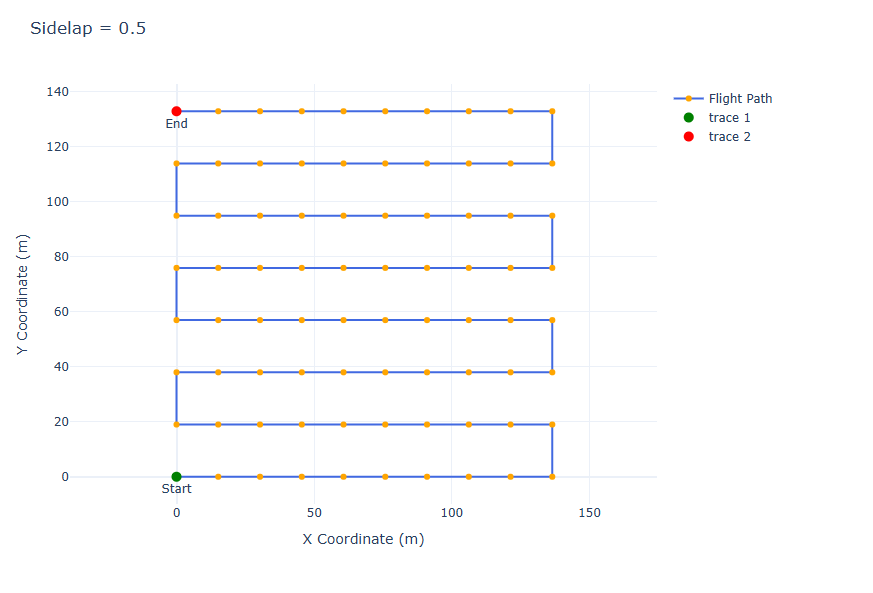

*Sidelap 0.8*


Explanation of Experiment
1. Input Parameter: The sidelap parameter is set to 0.8. Each photo overlaps 80% with the next image along the line.
2. Impact Observed: The flight path became closer together, forming a dense grid with significant overlap across the rows. The spacing between consecutive images along each row remained the same. 
3. Output: Higher sidelap reduces the lateral distance between flight paths. It leads to more redundant image coverage and minimizes gaps in side-to-side imaging. 


**How can a drone pilot use this result?**

A drone pilot can use high sidelap for detailed 3D terrain modelling. Especially in cases where maximum coverage and precision are more important than efficiency. 

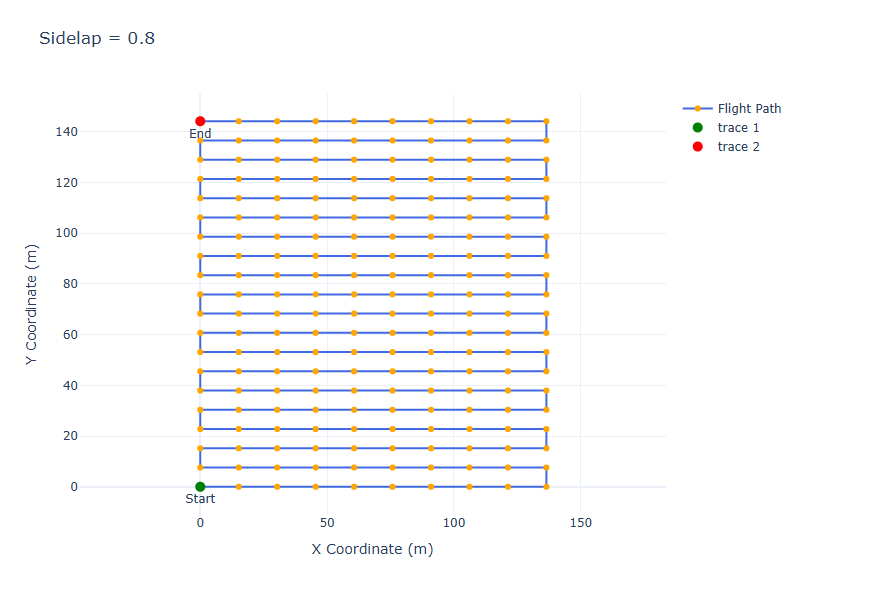

## Height

In [41]:
for h in [30, 60, 120]:  # heights in meters
    camera_ = copy.deepcopy(camera_x10)
    dataset_spec_ = copy.deepcopy(dataset_spec)
    dataset_spec_.height = h

    plan = generate_photo_plan_on_grid(camera_, dataset_spec_)
    print(f"Height {h}m → {len(plan)} waypoints")

    fig = plot_photo_plan(plan)
    fig.update_layout(title=f"Height = {h} m")
    fig.show(renderer="browser")


Height 30m → 154 waypoints
Height 60m → 42 waypoints
Height 120m → 12 waypoints


*Height 30m*


Explanation of Experiment
1. Input Parameter: The flight height is set to 30 meters. The drone's altitude increased to 30m during the scan.
2. Impact Observed: The photo plan shows more waypoints, as each image covers a smaller ground area. 
3. Output: At a lower altitude, each image covers smaller portion of the ground. The drone capture more photos as a result. This improves image detail since the ground sampling distance is smaller. 



**How can a drone pilot use this result?**

A drone pilot can use 30m altitude for detailed inspections or mapping smaller objects. It increases flight time and battery usage. 

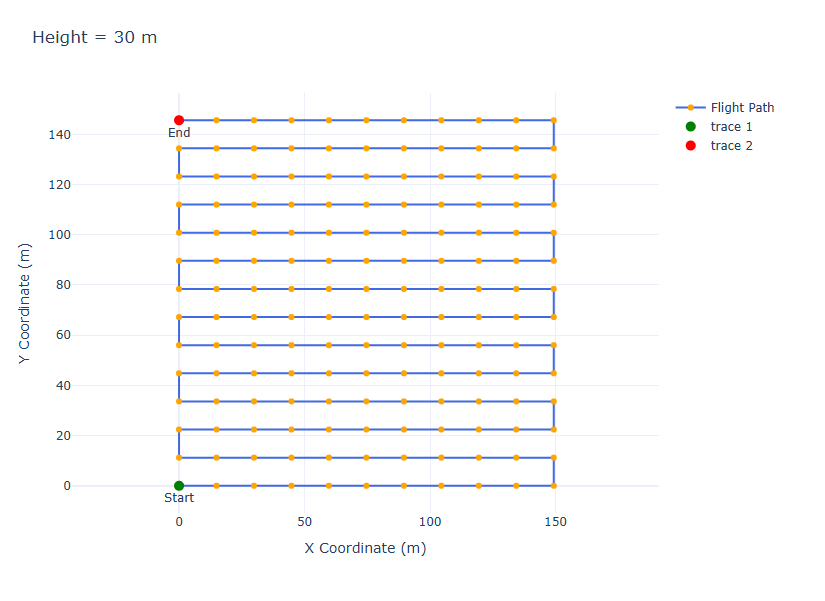

*Height 60m*


Explanation of Experiment
1. Input Parameter: The flight height is set to 60 meters. The drone's altitude increased to 60m during the scan.
2. Impact Observed: The photo plan shows fewer waypoints compared to 30m altitude, as each image now covers larger portion of the ground.
3. Output: As altitude doubles, the image footprint doubles in both width and height. It reduces the number of required photos to map the same area. GSD is higher as a result leading to coarser resolution.



**How can a drone pilot use this result?**

A drone pilot can use 60m for faster coverage and reduced battery usage when only general landscape features or large object need to be captured.  

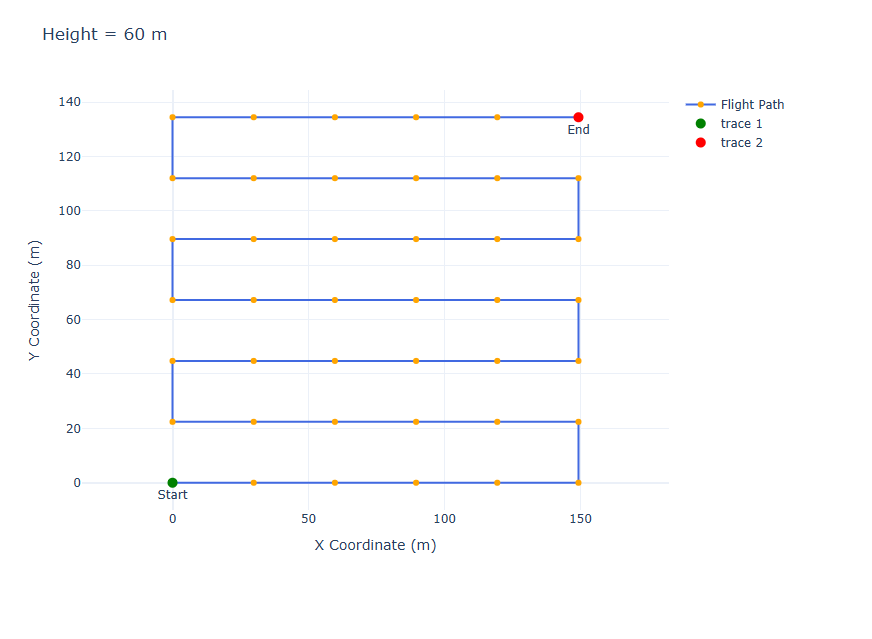

*Height 120m*


Explanation of Experiment
1. Input Parameter: The flight height is set to 120 meters. The drone's altitude increased to 120m during the scan.
2. Impact Observed: The scan plan becomes sparse with larger spacing between waypoints and fewer number of photoes required.  
3. Output: At higher altitudes, the drone camera captures wider ground area per shot. Each pixel represents a larger physical distance. 


**How can a drone pilot use this result?**

A drone pilot can use 120m altitude for high-level initial mapping but should avoid it for detailed inspections. 

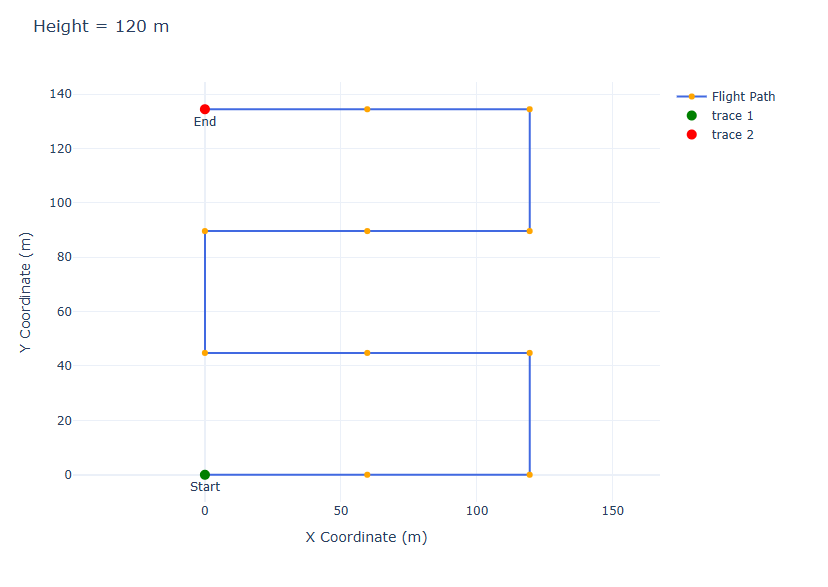

## Exposure Time

In [9]:
import plotly.graph_objects as go

exposure_times = [500, 1000, 2000]
max_speeds = []

for exp in exposure_times:
    camera_ = copy.deepcopy(camera_x10)
    dataset_spec_ = copy.deepcopy(dataset_spec)
    dataset_spec_.exposure_time_ms = exp
    speed = compute_speed_during_photo_capture(camera_, dataset_spec_)
    max_speeds.append(speed)

fig = go.Figure(
    data=[go.Bar(x=exposure_times, y=max_speeds, text=[f"{s:.3f}" for s in max_speeds], textposition="auto")]
)
fig.update_layout(
    title="Effect of Exposure Time on Allowable Drone Speed",
    xaxis_title="Exposure Time (ms)",
    yaxis_title="Max Speed (m/s)"
)
fig.show(renderer="browser")



*Exposure Time = 500ms* 

1. Input Parameter: Exposure time set to 500 ms.
2. Impact Observed: The allowable drone speed is higher compared to 1000ms and 2000ms. At 500 ms, the drone can move at ~0.012 m/s
3. Output: A longer exposure means the camera sensor collects light for more time. If the drone moves too fast, motion blur can occur, so it must slow down to keep captured image sharp.



**How can a drone pilot use this result?**

A drone pilot can use 500 ms for low-light conditions where a longer exposure is needed to brighten images without blur.


*Exposure Time = 1000 ms* 

1. Input Parameter: Exposure time increased to 1000 ms. 
2. Impact Observed: The allowable drone speed during photo capture decreases notably.  At 1000 ms it drops to ~0.006 m/s
3. Output: A longer exposure means camera sensor collects light for full second. To prevent motion blur, the drone must move slower so the image remains sharp during the extended exposure period.


**How can a drone pilot use this result?**

A drone pilot should reduce flight speed using 1000 ms exposure. It is helpful for low-light or dusk conditions where more light is needed but at the cost of slower coverage and longer flight time. 



*Exposure Time = 2000 ms* 

1. Input Parameter: Exposure time increased to 2000ms.
2. Impact Observed: The maximum allowable drone speed becomes very low to avoid motion blur. At 2000 ms, it falls further to ~0.003 m/s 
3. Output: A long exposure keeps the sensor open longer, even slight drone motions causes blur. The drone must slow down or hover nearly still during capture. 


**How can a drone pilot use this result?**

A drone pilot would only use this in extremely low-light environments or night operations with stationary captures.

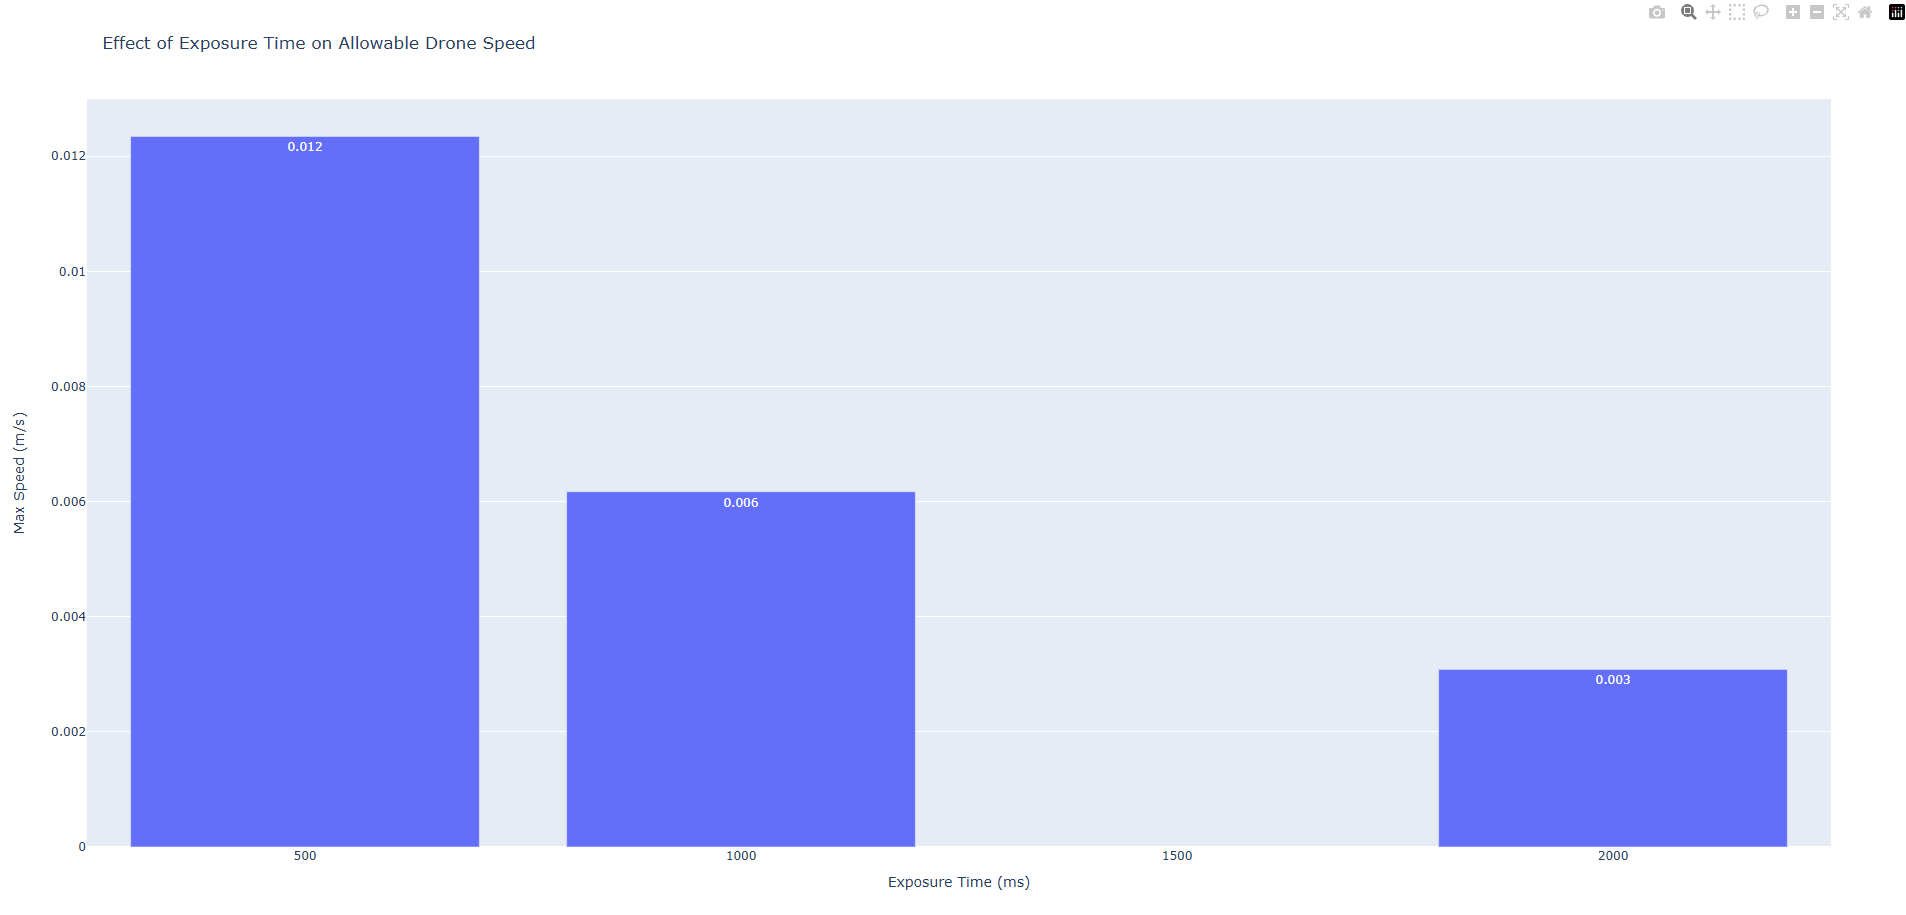